In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tables
import mplfinance as mpf
import my_afml_fncs as my_afml
from my_afml_fncs import dropLabels, movingAverageCrossover
from research import drop_label
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


Num of CPU core:  12
Machine info:  macOS-15.3-x86_64-i386-64bit
Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:45:13) [Clang 16.0.6 ]
Numpy 2.2.3
Pandas 2.2.3


In [2]:
volume_bars_df = pd.read_hdf("tick_data/bars/volume_bars.h5", key="volume_bars")
# volume_bars_df.head()
volume_bars_df.shape

(265, 6)

In [3]:
volume_bars_df['time']=pd.to_datetime(volume_bars_df['time'])
volume_bars_df.set_index('time',inplace=True)
# vol=my_afml.get_daily_volatility(volume_bars_df.close)
volume_bars_df.shape

(265, 5)

In [4]:
# get daily volatilities
vol=my_afml.getDailyVol(volume_bars_df.close)
vol.mean()
vol.shape

(247,)

In [5]:
# 3.1(a) apply CUSUM filet usings daily vols
es_cusum_events=my_afml.getTEvents(volume_bars_df.close,vol.mean())
es_cusum_events.shape

(48,)

In [6]:
# 3.1(b) get the t1 vertical barriers, with 1-day
t1=my_afml.getVb(volume_bars_df.close,es_cusum_events)
# t1

In [7]:
# 3.1(c) apply triple barrier method on the data with ptsl [1,1] and t1 as above, i assume target is daily vol
ptsl=[1,1]
trgt=vol.mean()*volume_bars_df.close
minRet=0.00003
numThread=1
trigger=my_afml.getEvents(volume_bars_df.close,es_cusum_events,ptsl,trgt,minRet,numThread,t1)
# print(trigger)
# print(trigger.shape)

Running processJobs_


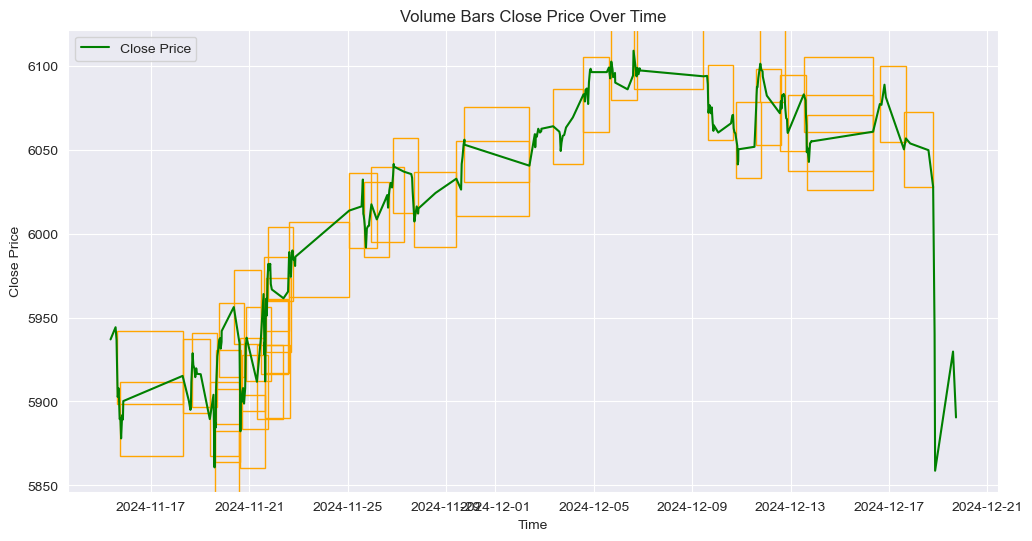

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='close', data=volume_bars_df, label='Close Price', color='green')

for start, t1, trgt in trigger.itertuples():
    box = Rectangle((start, volume_bars_df.close.loc[start] - vol.mean()*volume_bars_df.close.loc[start]), t1-start, 2*vol.mean()*volume_bars_df.close.loc[start],
                linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)


plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
# plt.legend()
plt.grid(True)
plt.show()



In [9]:
# 3.1(d) apply getBins to generate labels
bins=my_afml.getBins(trigger,volume_bars_df.close)
bins.head()

,ret,bin
2024-11-15 15:02:28.997004,-0.000845,-1.0
2024-11-15 17:32:19.288193,0.004372,1.0
2024-11-18 06:58:08.108243,-0.004353,-1.0
2024-11-18 16:00:36.713567,-0.000211,-1.0
2024-11-19 09:28:48.026253,0.007683,1.0


In [10]:
# 3.2 drop rare labels
post_drop_bins=dropLabels(bins)
post_drop_bins.head()

,ret,bin
2024-11-15 15:02:28.997004,-0.000845,-1.0
2024-11-15 17:32:19.288193,0.004372,1.0
2024-11-18 06:58:08.108243,-0.004353,-1.0
2024-11-18 16:00:36.713567,-0.000211,-1.0
2024-11-19 09:28:48.026253,0.007683,1.0


In [11]:
# Define moving average windows
short_window = 50  # e.g., 50 periods
long_window = 200  # e.g., 200 periods

In [12]:
# create events where the moving averages cross over
events=my_afml.movingAverageCrossover(volume_bars_df.close,short_window,long_window)
events.head()

,short_ma,long_ma,signal
time,,,
2024-11-15 08:39:56.469400,5937.000000,5937.000000,-1
2024-11-15 13:33:55.913324,5940.625000,5940.625000,-1
2024-11-15 14:30:17.843538,5939.333333,5939.333333,-1
2024-11-15 14:43:36.170628,5937.000000,5937.000000,-1
2024-11-15 15:02:28.997004,5933.650000,5933.650000,-1


In [13]:
volume_bars_df.close.shape

(265,)

In [14]:
# and add vertical barrier 1 day from those events
t1=my_afml.getVb(volume_bars_df.close,events.index)

In [15]:
# now set ptsl to be lopsided [1,2] which we can do because we now have a 'side' from the moving average crossover
ptsl=[1,2]
# target is set to be standard deviation
trgt=vol.mean()*volume_bars_df.close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
trigger=my_afml.getEvents(volume_bars_df.close,events.index,ptsl,trgt,minRet,numThread,t1,events.signal)


Running processJobs


2025-02-20 07:37:12.843005 100.0% applyPtSlOnT1 done after 0.03 minutes. Remaining 0.0 minutes..


In [22]:
trigger.head()

,t1,trgt,side
time,,,
2024-11-15 08:39:56.469400,2024-11-18 06:58:08.108243,22.015023,-1
2024-11-15 13:33:55.913324,2024-11-18 06:58:08.108243,22.041907,-1
2024-11-15 14:30:17.843538,2024-11-18 06:58:08.108243,22.014096,-1
2024-11-15 14:43:36.170628,2024-11-18 06:58:08.108243,21.989066,-1
2024-11-15 15:02:28.997004,2024-11-18 06:58:08.108243,21.952912,-1


In [17]:
# getBins will generate the meta-label as we provide a side now
bins=my_afml.getBins(trigger,volume_bars_df.close)

In [23]:
bins.head()

,ret,bin
time,,
2024-11-15 08:39:56.469400,0.003663,1.0
2024-11-15 13:33:55.913324,0.004879,1.0
2024-11-15 14:30:17.843538,0.003622,1.0
2024-11-15 14:43:36.170628,0.002487,1.0
2024-11-15 15:02:28.997004,0.000845,1.0


In [25]:
volume_bars_df.head()

,open,high,low,close,volume
time,,,,,
2024-11-15 08:39:56.469400,5967.00,5968.00,5930.75,5937.00,100001
2024-11-15 13:33:55.913324,5937.25,5953.25,5936.25,5944.25,100003
2024-11-15 14:30:17.843538,5944.50,5947.75,5935.00,5936.75,100040
2024-11-15 14:43:36.170628,5936.75,5941.75,5929.25,5930.00,100037
2024-11-15 15:02:28.997004,5929.75,5940.50,5920.00,5920.25,100002


In [29]:
volume_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(volume_bars_df.close, short_window, long_window)
volume_bars_df['std']=my_afml.getDailyVol(volume_bars_df.close)
volume_bars_df.head(20)


,open,high,low,close,volume,short_ma,long_ma,signal,std
time,,,,,,,,,
2024-11-15 08:39:56.469400,5967.00,5968.00,5930.75,5937.00,100001,5937.000000,5937.000000,-1,NaN
2024-11-15 13:33:55.913324,5937.25,5953.25,5936.25,5944.25,100003,5940.625000,5940.625000,-1,NaN
2024-11-15 14:30:17.843538,5944.50,5947.75,5935.00,5936.75,100040,5939.333333,5939.333333,-1,NaN
2024-11-15 14:43:36.170628,5936.75,5941.75,5929.25,5930.00,100037,5937.000000,5937.000000,-1,NaN
2024-11-15 15:02:28.997004,5929.75,5940.50,5920.00,5920.25,100002,5933.650000,5933.650000,-1,NaN
2024-11-15 15:16:29.237773,5920.25,5923.00,5910.75,5912.00,100003,5930.041667,5930.041667,-1,NaN
2024-11-15 15:36:30.954732,5912.00,5914.50,5902.00,5902.75,100002,5926.142857,5926.142857,-1,NaN
2024-11-15 15:55:21.668668,5902.75,5915.50,5902.00,5903.50,100011,5923.312500,5923.312500,-1,NaN
2024-11-15 16:22:14.681362,5903.50,5911.75,5899.00,5908.00,100003,5921.611111,5921.611111,-1,NaN


In [30]:
# now fit same data using these labels
X=volume_bars_df.loc[bins.index,:]
y=bins['bin']

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
features = X
labels = bins['bin']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85        38
         1.0       0.87      0.82      0.85        40

    accuracy                           0.85        78
   macro avg       0.85      0.85      0.85        78
weighted avg       0.85      0.85      0.85        78



In [17]:

set_diff = volume_bars_df.index.difference(bins.index)
print(set_diff)


DatetimeIndex(['2024-11-15 08:39:56.469400', '2024-11-15 13:33:55.913324',
               '2024-11-15 14:30:17.843538', '2024-11-15 14:43:36.170628',
               '2024-11-15 15:16:29.237773', '2024-11-15 15:36:30.954732',
               '2024-11-15 15:55:21.668668', '2024-11-15 16:22:14.681362',
               '2024-11-15 16:54:42.150243', '2024-11-15 18:14:38.726140',
               ...
               '2024-12-16 19:39:50.270022', '2024-12-16 20:59:59.504389',
               '2024-12-17 16:31:24.270556', '2024-12-17 20:45:34.771591',
               '2024-12-18 14:34:03.919800', '2024-12-18 19:08:29.806640',
               '2024-12-18 20:33:00.914784', '2024-12-18 21:03:19.567693',
               '2024-12-19 14:32:08.428649', '2024-12-19 17:26:20.544849'],
              dtype='datetime64[ns]', length=222, freq=None)
